# Generowanie danych symulujących jazdę platformy robotycznej

Ten dokument prezentuje i opisuje metody generacji danych imitujących dane zwracane przez czujniki przeznaczone do śledzenia trasy przebytej przez platformę robotyczną.
Te dane zostaną następnie użyte do zweryfikowania poprawności działania filtru Kalmana, oraz algorytmów mapujących je na trasę w formie punktów na płaszczyźnie dwuwymiarowej.

## Rodzaje badanych modułów

Badane będą dane z następujących modułów:

* Akcelerometr <!-- i żyroskop --> (MPU-6050)
* Enkoder wieloobrotowy (przymocowany do osi koła via przełożenie)
* Moduł optical-flow (ADNS3080)
* Kamera Intel RealSense T265

Dla każdego z modułów zostanie stworzony uproszczony model teoretyczny, pozwalający na generowanie danych z uwzględnieniem ich niedokładności.

Uwzględniane parametry (oraz domyślne wartości na podstawie danych z dokumentacji i testów znalezionych w internecie):

* Dla MPU-6050:
    * Zakładamy parametry czujnika przy temperaturze 25*C (ignorujemy dryft temperaturowy w celu uproszczenia modelu), przy warunkach określonych w datasheecie
    <!-- * Dla żyroskopu:
        * Full-Scale Range ($\text{FSR}$, $\text{[º/s]}$), precyzja sterowana wzmocnieniem przetwornika żyroskopu - od ±250º/s do ±2000º/s
        * Sensitivity Scale Factor ($\text{SSF}$, $\text{[LSB/(º/s)]}$), współczynnik czułości - 131 / 65.5 / 32.8 / 16.4 LSB/(º/s) przy FSR równym 250, 500, 1000 i 2000 º/s
        * Cross-Axis Sensitivity ($\text{CAS}$, $\text{[\%]}$), czułość międzyosiowa, przykładowo: wpływ ruchu w osi X oraz Z na odczyt z osi Y - 2%
        * Zero-Rate Output ($\text{ZRO}$, $\text{[º/s]}$), wartość wyjściowa przy braku ruchu - ±20º/s
        * Szum (błąd) względny pojedynczego pomiaru ($\delta$, $\text{[\%]}$): ±3%
        * Szum (błąd) bezwzględny pojedynczego pomiaru ($\Delta$, $\text{[deg/s-rms]}$): 0.05º/s-rms -->
    * Dla akcelerometru:
        * Full-Scale Range ($\text{FSR}$, $\text{[g]}$) - od ±2g do ±16g
        * Sensitivity Scale Factor ($\text{SSF}$, $\text{[LSB/g]}$) - 16384 / 8192 / 4096 / 2048 LSB/g przy FSR równym 2 / 4 / 8 / 16 g
        * Cross-Axis Sensitivity ($\text{CAS}$, $\text{[\%]}$) - 2%
        * Zero-Rate Output ($\text{ZRO}$, $\text{[mg]}$) - ±50 mg dla osi X i Y, ±80 mg dla osi Z
        * Szum (błąd) względny pojedynczego pomiaru ($\delta$, $\text{[\%]}$): ±3%
* Dla enkodera:
    * Częstotliwość pomiaru ($\text{f}$, $\text{[Hz]}$) - do ustalenia, wstępnie 50Hz
    * 400 kroków na obrót (Counts Per Turn, $\text{CPT}$)
    * Przełożenie $k = 3$ (ze względu na sposób montażu)
    * Błąd względny ($\delta$, $\text{[\%]}$) - 1%
* Dla ADNS3080:
    * Framerate - od 2000 do 6000 FPS
    * Rozdzielczość - od 400 do 1600 cpi (counts per inch)
    * Błąd bezwzględny ($\Delta$, $\text{[mc]}$ (mouse count)) - 5mc, w celu obliczenia dystansu należy podzielić tą wartość przez rozdzielczość
    * Błąd względny ($\delta$, $\text{[\%]}$) - 2%
    * Ze względu na nietypowe zastosowanie (czujnik jest przeznaczony m.in do myszek komputerowych), parametry z dokumentacji mogą nie być adekwatne do rzeczywistych parametrów uzyskanych w urządzeniu, będzie konieczna ręczna kalibracja.
* Dla Intel RealSense T265:
    * Błąd względny ($\delta$, $\text{[\%]}$) - 1%


## Symulacja MPU-6050 (akcelerometr i żyroskop)

MPU-6050 to cyfrowy 3-osiowy akcelerometr/żyroskop. Pomimo wykorzystania tylko 2 osi w badaniach (X oraz Y), oś Z również zostanie symulowana ze względu na CAS, które powoduje że teoretycznie zmiany w osi Z mogą wpływać na odczyty z osi X oraz Y. 

Zaczniemy od symulacji pojedynczej osi, z założeniem że dane zwracane przez moduł są idealne. Następnie zostaną dodane kolejne źródła zakłóceń z możliwością ich parametryzacji.

Załóżmy że dane generowane przez moduł mają rozkład jednostajny, a szumy i niedokładności będą miały rozkład normalny (Gaussa). Przykładowy kod generujący losową wartość z zakresu $[a, b)$ o rozkładzie jednostajnym można wygenerować w następujący sposób:

In [1]:
import numpy as np

a = 0
b = 10

generator = np.random.default_rng()  
print(generator.uniform(a, b))


8.995682071951304


Generując losowe wartości nie otrzymamy danych przypominających te odczytane z czujnika podczas jazdy. Gdyby wartości które otrzymamy z takiego generatora zostały zmapowane na trasę, otrzymalibyśmy dużo losowych punktów skupionych wokół punktu startu. Potencjalnym rozwiązaniem tego problemu jest dodanie logiki do generatora, która będzie sterować zakresem generowanych wartości w zależności od założonego kierunku oraz przyspieszenia.

Podczas przyspieszania i zwalniania, przeciążenie powinno rosnąć a następnie maleć, proporcjonalnie do zmiany zakładanej szybkości pojazdu. Podczas jednostajnej jazdy, przyspieszenie powinno być niskie i powinny być widoczne zakłócenia związane z wibracjami i chwilowymi zmianami w szybkości pojazdu.

Mamy więc trzy możliwe scenariusze - przyspieszanie, zwalnianie oraz ruch jednostajny. Parametrami dla pierwszych dwóch powinna być szybkość startowa, szybkość docelowa i czas zmiany szybkości.

### Symulacja przyspieszania pojazdu

Zakładamy że przyspieszenie jest jednostajne. Zaczniemy od wygenerowania danych dotyczących przyspieszenia w czasie, które następnie zamienimy na przeciążenie.

Amount of time points: 100
Acceleration: 0.20202020202020202
g-force: 0.20394324259558566


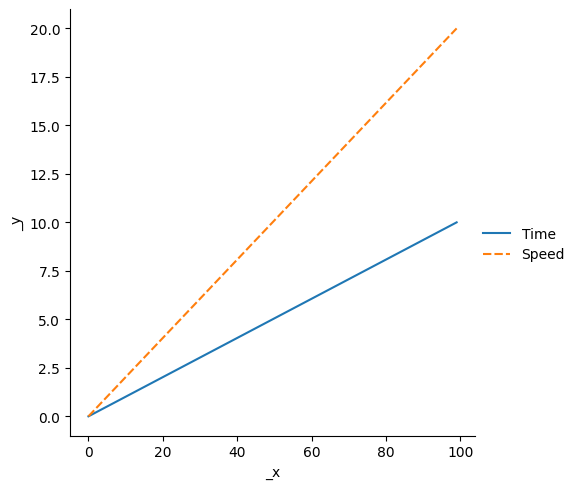

In [2]:
from typing import List, Tuple
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy.constants import g as g_constant

# The code is unit-agnostic for now, but later we'll have to specify units for correct g-force calculations, so let's assume that speed unit is meters and time units are seconds

def calculate_g_force(start_speed: float, target_speed: float, acceleration_time: float):
    return (target_speed - start_speed) / (acceleration_time * g_constant)

def generate_acceleration_data(
    start_speed: float, target_speed: float, acceleration_time: float, time_step: float
) -> Tuple[List[float], List[float], float, float]:
    time_points_count = int(acceleration_time / time_step)
    # Create an array with all the time points where measurements happened
    time_points = np.linspace(0, acceleration_time, time_points_count)
    # Map the time points to speed
    speed_in_time = [
        np.interp(time_point, [0, acceleration_time], [start_speed, target_speed])
        for time_point in time_points
    ]
    # Calculate the acceleration from speed change
    acceleration = speed_in_time[1] - speed_in_time[0]
    g_force = calculate_g_force(start_speed, target_speed, acceleration_time)

    return time_points, speed_in_time, acceleration, g_force


# Assume acceleration from 0 to 20 m/s, in 5 seconds, with 0.1s measurement frequency
time, speed, acceleration, g_force = generate_acceleration_data(0, 20, 10, 0.1)

print(f"Amount of time points: {len(time)}")
print(f"Acceleration: {acceleration}")
print(f"g-force: {g_force}")


# Visualize the data
acceleration_dataframe = pd.DataFrame(
    list(zip(time, speed)), columns=["Time", "Speed"]
)

sns.relplot(data=acceleration_dataframe, kind="line")


Jak widać na powyższym wykresie, wygenerowane dane są prawidłowe - akceleracja jest stała, szybkość osiąga 20m/s a czas 5s. Zgadza się również częstotliwość pomiarów - mierząc dane przez 5 sekund z częstotliwością 10Hz otrzymujemy 50 próbek.
Można zastosować inny wzór na obliczanie przeciążenia - $\text{G force} = \frac{a}{g}$, gdzie $a$ to akceleracja w $\frac{m}{s^2}$, a $g$ to stała grawitacyjna.